# Gemini evidence citation

This notebook attempts to use Gemini in order to extract AABB (axis-aligned bounding boxes) from OCR results.

## Prerequisites
`$ gcloud auth application-default login`

## Approaches tested
- Using tokens
- TODO: using lines or blocks

## Libraries used
- vertexai & google-cloud-aiplatform
- google-cloud-documentai
- pypdf
- PyMuPDF (fitz)
- Pillow (PIL)

## Documents used
- [minnie_mouse.pdf](./minnie_mouse.pdf)

## Results
Gemini 1.5 seems particularly good at this.

In [1]:
PROJECT_ID = 'viki-dev-app-wsky'
LOCATION = 'us-central1'
MODEL = 'gemini-1.5-pro-preview-0409'

# Initialize AI libraries and helper functions

In [2]:
from typing import List, Union, Tuple
from io import BytesIO

import vertexai
from vertexai.language_models import TextGenerationModel, TextEmbeddingModel
from vertexai.generative_models import GenerativeModel, Part, FinishReason, HarmCategory, HarmBlockThreshold
from google.cloud import aiplatform
import pypdf
import fitz  # PyMuPDF
from IPython.display import display
from PIL import Image, ImageDraw

vertexai.init(project=PROJECT_ID, location=LOCATION)
aiplatform.init(project=PROJECT_ID, location=LOCATION)

def predict(prompt_text):
    """
    text-bison prompt
    """
    generation_model = TextGenerationModel.from_pretrained('text-bison-32k@002')
    generation_config = {"max_output_tokens": 8192, "temperature": 0.2, "top_p": 1}
    response = generation_model.predict(
        prompt_text,
        max_output_tokens=generation_config.get("max_output_tokens"),
        temperature=generation_config.get("temperature"),
        top_p=generation_config.get("top_p"),
    )
    answer = response.text
    return answer

def multi_modal_predict(items: List[Union[str, Tuple[bytes, str]]], model="gemini-1.5-pro-preview-0409"):
    """
    gemini multi-modal prompt

    `items` is a list of tuples, where each tuple is either a string or a tuple of bytes and a string of the mime type.

    e.g.:
    items = [
        "This is a string",
        (b"this is a byte string", "application/pdf"),
        (b"this is a byte string", "image/jpeg"),
    ]
    """

    contents = []
    for item in items:
        if isinstance(item, str):
            contents.append(Part.from_text(item))
        else:
            contents.append(Part.from_data(data=item[0], mime_type=item[1]))

    generation_config = {
        "max_output_tokens": 8192,
        "temperature": 1,
        "top_p": 0.95,
    }

    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    }

    model = GenerativeModel(model)
    return model.generate_content(
        contents,
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=True,
    )

In [3]:
# predict('Give me a random number')
for x in multi_modal_predict('Give me 10 random numbers'):
    print(x.text, end='')

1. 42
2. 17
3. 93
4. 22
5. 58
6. 71 
7. 34
8. 89
9. 10
10. 65 


# Extract medication page from PDF
This section extracts a single page from PDF and also converts it to image for visualization purposes.

Single-page PDF size: 170468


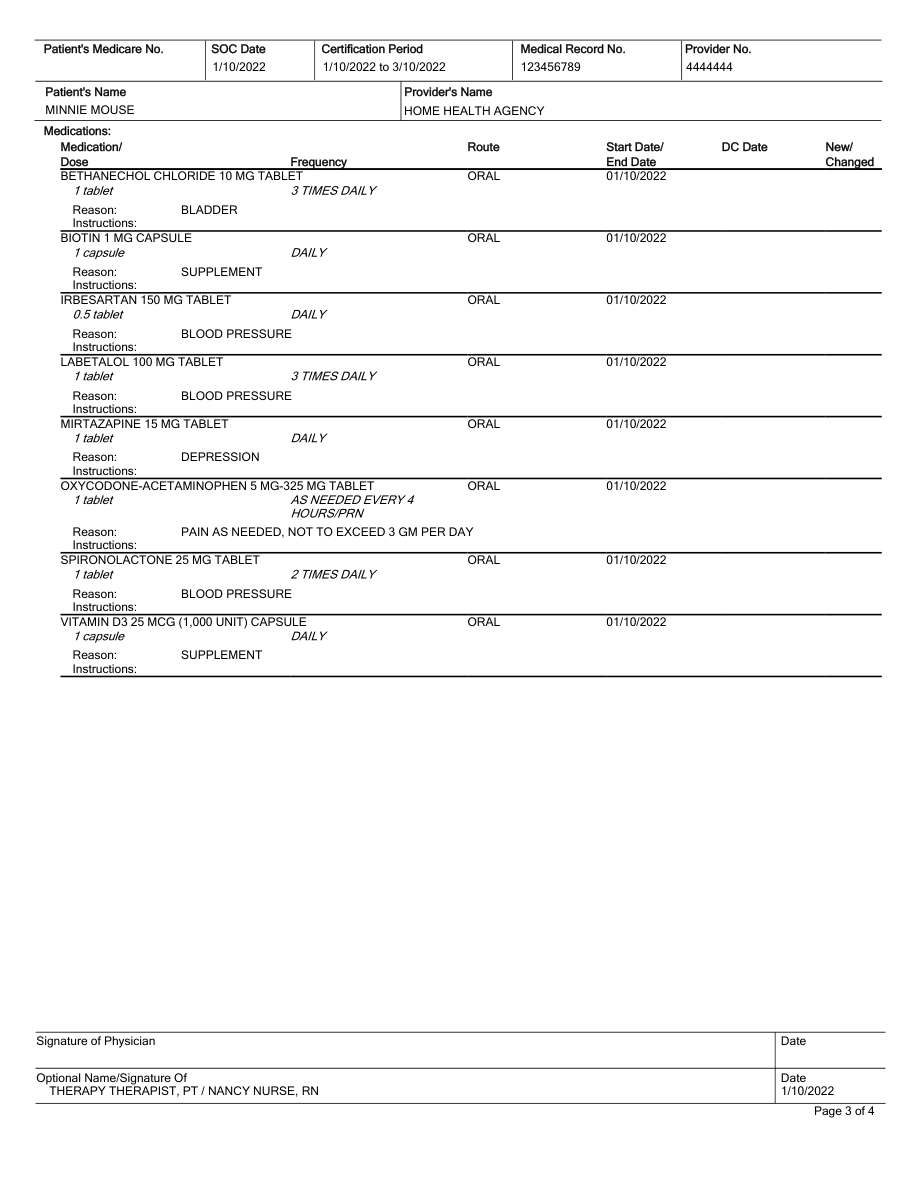

In [4]:
PAGE = 2 # Page 3 - medications

# Read page
pdf_reader = pypdf.PdfReader('./minnie_mouse.pdf')
page = pdf_reader.pages[PAGE]

# Save page as separate PDF
page_pdf_buffer = BytesIO()
page_writer = pypdf.PdfWriter()
page_writer.add_page(page)
page_writer.write(page_pdf_buffer)
page_pdf_buffer.seek(0)
page_pdf_content = page_pdf_buffer.getvalue()
print(f'Single-page PDF size: {len(page_pdf_content)}')

# Open page with PyMuPDF
doc = fitz.open(stream=page_pdf_content)
# Get first (and only) page
page = doc[0]
# Extract as PNG
pixmap = page.get_pixmap(matrix=fitz.Matrix(1.5, 1.5))  # Scale by 1.5x1.5
png_data = pixmap.tobytes()

# Construct PIL image
original_img = Image.open(BytesIO(png_data))

display(original_img)

# Perform OCR
This section uses Google Document AI to extract text features from the PDF page.

In [5]:
# Perform OCR

from google.cloud import documentai
from google.api_core.client_options import ClientOptions

# Perform OCR with DocumentAI
docai = documentai.DocumentProcessorServiceClient(client_options=ClientOptions(api_endpoint=f"us-documentai.googleapis.com"))
hcc = docai.processor_version_path('viki-dev-app-wsky', 'us', '7359477870825dbb', 'pretrained')
documentai.RawDocument()
ocr_response = docai.process_document(
    request=documentai.ProcessRequest(
        name=hcc,
        raw_document=documentai.RawDocument(
            content=page_pdf_content,
            mime_type='application/pdf',
        ),
        process_options={}
    )
)

# Calculate AABB (axis-aligned bounding boxes) and prepare data for LLM prompt

In [6]:
# Generate list of texts with bounding boxes
from collections import namedtuple
Token = namedtuple('Token', ('text', 'x1', 'y1', 'x2', 'y2'))
tokens = []
ocr_page = ocr_response.document.pages[0]

# for item in ocr_page.tokens:
for item in ocr_page.lines:
# for item in ocr_page.blocks:
    segments = item.layout.text_anchor.text_segments[0]
    start, end = segments.start_index, segments.end_index
    text = ocr_response.document.text[start:end]
    x1 = min(vert.x for vert in item.layout.bounding_poly.normalized_vertices)
    y1 = min(vert.y for vert in item.layout.bounding_poly.normalized_vertices)
    x2 = max(vert.x for vert in item.layout.bounding_poly.normalized_vertices)
    y2 = max(vert.y for vert in item.layout.bounding_poly.normalized_vertices)
    x1, y1, x2, y2 = map(lambda v: int(v * 1000) / 1000, (x1, y1, x2, y2))  # Round to 1/1000, which corresponds to <=1px error for every 1000px
    tokens.append(Token(text, x1, y1, x2, y2))
print(tokens)

[Token(text="Patient's Medicare No.\n", x1=0.047, y1=0.036, x2=0.178, y2=0.044), Token(text="Patient's Name\n", x1=0.049, y1=0.073, x2=0.138, y2=0.081), Token(text='MINNIE MOUSE\n', x1=0.05, y1=0.088, x2=0.146, y2=0.096), Token(text='Medications:\n', x1=0.047, y1=0.105, x2=0.122, y2=0.113), Token(text='Medication/\n', x1=0.065, y1=0.119, x2=0.133, y2=0.127), Token(text='Dose\n', x1=0.065, y1=0.131, x2=0.096, y2=0.139), Token(text='Reason:\n', x1=0.079, y1=0.172, x2=0.126, y2=0.18), Token(text='Instructions:\n', x1=0.079, y1=0.184, x2=0.15, y2=0.191), Token(text='BIOTIN 1 MG CAPSULE\n', x1=0.066, y1=0.196, x2=0.207, y2=0.203), Token(text='1 capsule\n', x1=0.081, y1=0.208, x2=0.135, y2=0.218), Token(text='BETHANECHOL CHLORIDE 10 MG TABLET\n', x1=0.065, y1=0.143, x2=0.329, y2=0.152), Token(text='1 tablet\n', x1=0.081, y1=0.156, x2=0.124, y2=0.164), Token(text='Reason:\n', x1=0.079, y1=0.224, x2=0.127, y2=0.232), Token(text='Instructions:\n', x1=0.079, y1=0.236, x2=0.15, y2=0.243), Token(t

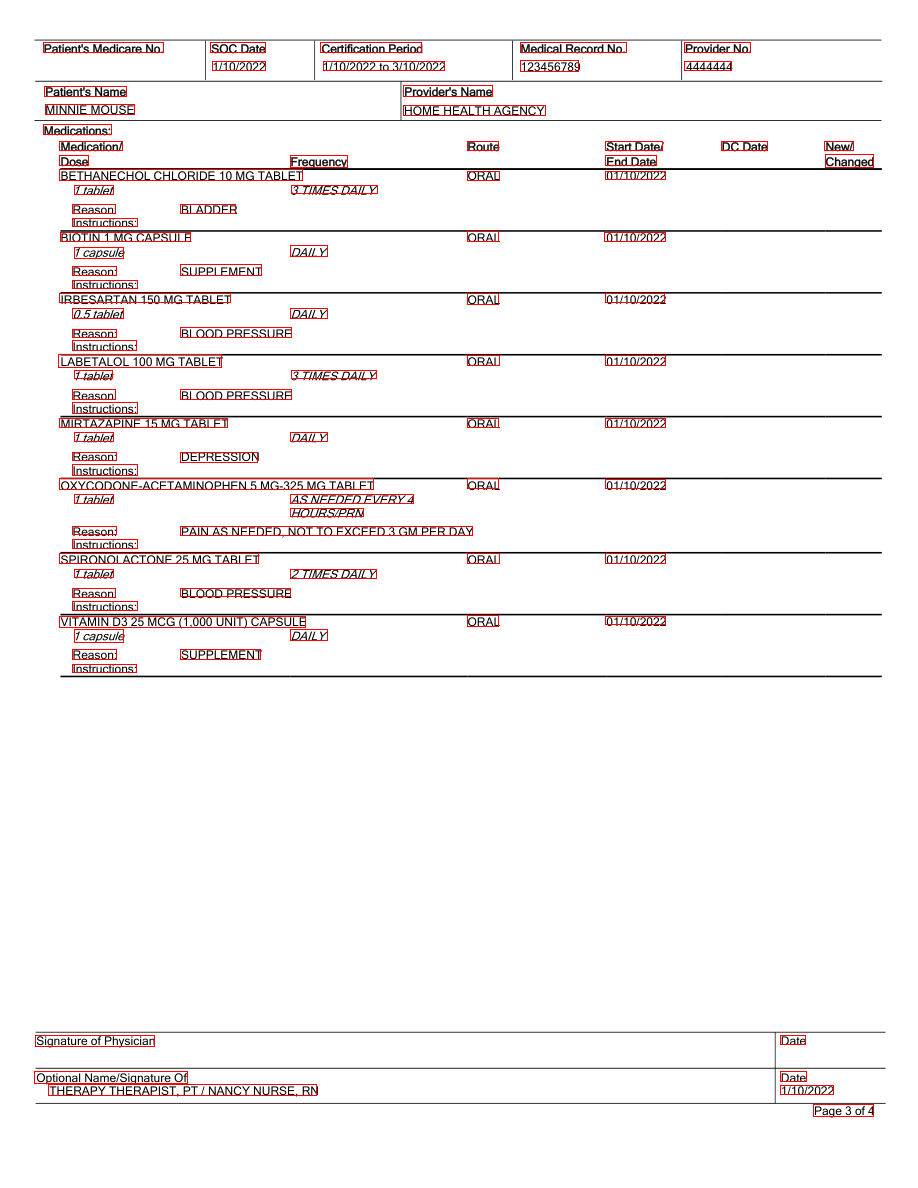

In [7]:
# Visualize tokens to ensure everything is good so far
img = original_img.copy()
draw = ImageDraw.Draw(img)
for token in tokens:
    draw.rectangle((token.x1 * img.width, token.y1 * img.height, token.x2 * img.width, token.y2 * img.height), outline='#FF0000')
img

In [8]:
# Generate Markdown table for Gemini prompt (it seems to be particularly good with Markdown)
table = ''
for token in tokens:
    table += ' | '.join(map(lambda x: str(x).strip().replace('\n', '\\n'), [''] + list(token) + [''])).strip() + '\n'
print(table)

| Patient's Medicare No. | 0.047 | 0.036 | 0.178 | 0.044 |
| Patient's Name | 0.049 | 0.073 | 0.138 | 0.081 |
| MINNIE MOUSE | 0.05 | 0.088 | 0.146 | 0.096 |
| Medications: | 0.047 | 0.105 | 0.122 | 0.113 |
| Medication/ | 0.065 | 0.119 | 0.133 | 0.127 |
| Dose | 0.065 | 0.131 | 0.096 | 0.139 |
| Reason: | 0.079 | 0.172 | 0.126 | 0.18 |
| Instructions: | 0.079 | 0.184 | 0.15 | 0.191 |
| BIOTIN 1 MG CAPSULE | 0.066 | 0.196 | 0.207 | 0.203 |
| 1 capsule | 0.081 | 0.208 | 0.135 | 0.218 |
| BETHANECHOL CHLORIDE 10 MG TABLET | 0.065 | 0.143 | 0.329 | 0.152 |
| 1 tablet | 0.081 | 0.156 | 0.124 | 0.164 |
| Reason: | 0.079 | 0.224 | 0.127 | 0.232 |
| Instructions: | 0.079 | 0.236 | 0.15 | 0.243 |
| IRBESARTAN 150 MG TABLET | 0.065 | 0.247 | 0.251 | 0.255 |
| 0.5 tablet | 0.079 | 0.26 | 0.134 | 0.268 |
| Reason: | 0.079 | 0.381 | 0.127 | 0.388 |
| Instructions: | 0.079 | 0.391 | 0.15 | 0.4 |
| SOC Date | 0.229 | 0.036 | 0.289 | 0.044 |
| 1/10/2022 | 0.231 | 0.052 | 0.289 | 0.059 |
| Reason: | 0

# Perform evidence citation using LLM prompt (Gemini v1.5)

In [25]:
inputs = [
    'Medication: BIOTIN 1 MG Capsule dose: 1 CAPSULE reason: supplement frequency: daily route: oral start date: 1/10/22',
    'Medication: SPIRONOLACTONE 25 MG TABLET dose: 1 tablet reason: abnormal blood pressure daily route: oral start date: 1/10/22',
]

prompt = [
    'Below is the table that contains tokens found on page along with their normalized AABB coordinates (x1, y1, x2, y2)',
    'These medications are spatially arranged as a set of rows with consistent structure across all medications on the page.  Therefore, when mapping, take into account the spatial arrangement and output the bounding box coordinates that are located close together and not something from a different medication row.',
    '```',
    table,
    '```',
    'We are looking for a sequence of those blocks that are located close to each other and show the following texts:',
    *[f'- `{input}`' for input in inputs],
    'RULES:',
    '- For each requested text, provide all table entries that show this text.',
    '- For each requested text, print result as markdown table with 5 columns and no header column.',
    '- Do not include any header titles or other markdown formatting: only markdown tables.',
    '- Separate tables from each other with a triple dash ("---").',
]
# print('\n'.join(prompt))
response = multi_modal_predict(prompt)

results = []
for chunk in response:
    print(chunk.text, end='')
    results.append(chunk.text)

result = ''.join(results)

| BIOTIN 1 MG CAPSULE | 0.066 | 0.196 | 0.207 | 0.203 |
| 1 capsule | 0.081 | 0.208 | 0.135 | 0.218 |
| SUPPLEMENT | 0.197 | 0.223 | 0.285 | 0.232 |
| DAILY | 0.316 | 0.207 | 0.357 | 0.216 |
| ORAL | 0.509 | 0.195 | 0.543 | 0.203 |
| 01/10/2022 | 0.659 | 0.196 | 0.725 | 0.203 |

---

| SPIRONOLACTONE 25 MG TABLET | 0.065 | 0.466 | 0.282 | 0.474 |
| 1 tablet | 0.081 | 0.479 | 0.124 | 0.486 |
| BLOOD PRESSURE | 0.197 | 0.495 | 0.316 | 0.502 |
| DAILY | 0.316 | 0.479 | 0.357 | 0.487 |
| ORAL | 0.509 | 0.466 | 0.544 | 0.474 |
| 01/10/2022 | 0.66 | 0.466 | 0.725 | 0.474 | 


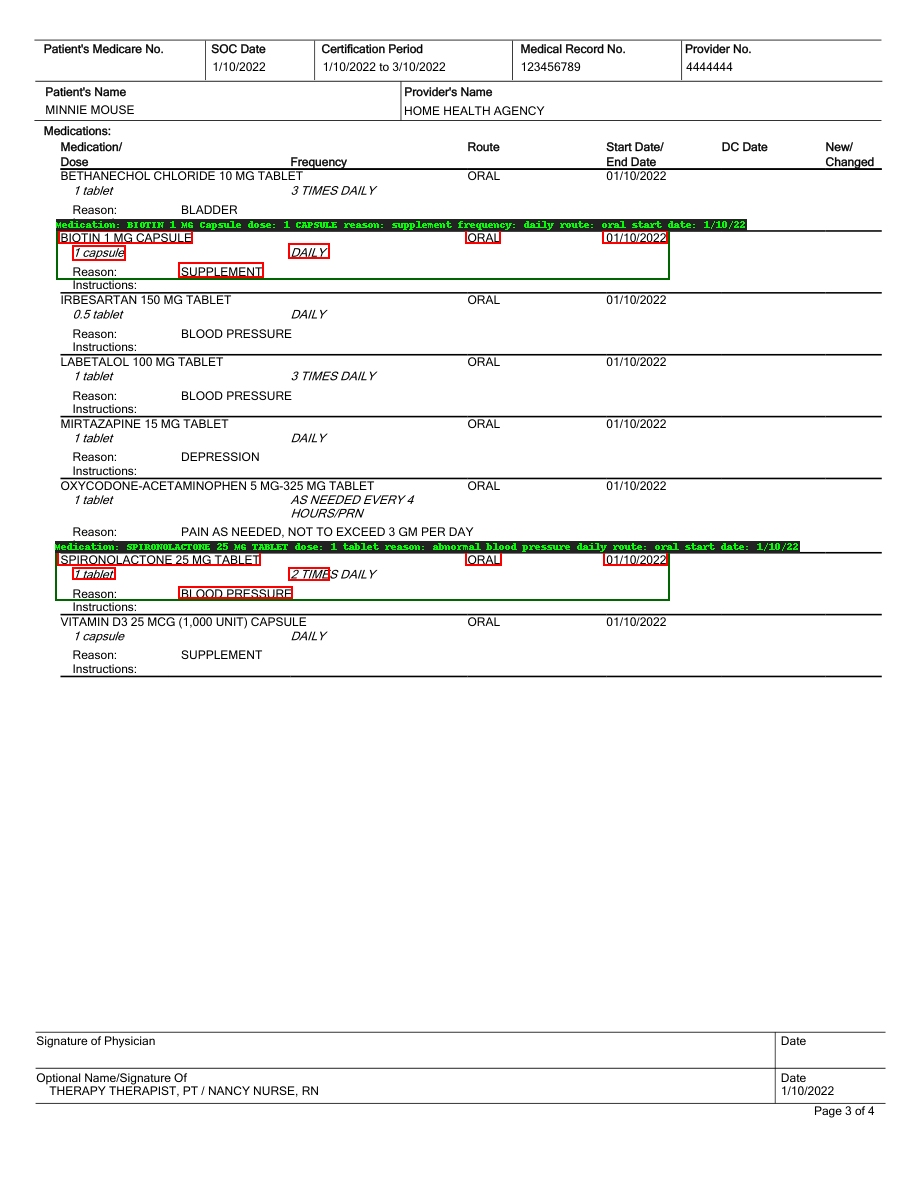

In [41]:
import re

img = original_img.copy()

from typing import List, Tuple

def extract_results(result: str) -> List[Tuple[List, Token]]:
    """
    Parse response from LLM, extract matched lines and calculate their bounding boxes.

    Returns a list of tuples, each tuple contains list of line tokens as 1st element and a dummy AABB token as 2nd element
    """
    results = []

    for table_text in result.split('---'):
        # Collect all rows
        lines = []
        for line in filter(None, table_text.split('\n')):
            if line.startswith('|'):
                # We're inside table
                try:
                    _, text, x1, y1, x2, y2, _ = line.split('|')
                    x1, y1, x2, y2 = map(lambda x: float(x.strip()), (x1, y1, x2, y2))
                    assert x2 >= x1
                    assert y2 >= y1
                    lines.append(Token(text, x1, y1, x2, y2))
                    # bbox[-1] = Token('', min(bbox[-1].x1, x1), min(bbox[-1].y1, y1), max(bbox[-1].x2, x2), max(bbox[-1].y2, y2))
                except Exception as exc:
                    print(f'Warning: line {repr(line)} failed to parse: {exc}')
            else:
                print(f'WARNING: Text is malformed, this branch should never be reached, line: {repr(line)}')
        # Calculate AABB
        min_x = min([line.x1 for line in lines])
        min_y = min([line.y1 for line in lines])
        max_x = max([line.x2 for line in lines])
        max_y = max([line.y2 for line in lines])
        results.append((lines, Token('', min_x, min_y, max_x, max_y)))
    return results

# Draw stuff

padding = 2
results = extract_results(result)
draw = ImageDraw.Draw(img)
img_w, img_h = img.size

for i, (lines, bbox) in enumerate(results):
    for line in lines:
        # Draw line AABB
        draw.rectangle(
            (line.x1 * img.width - padding, line.y1 * img.height - padding, line.x2 * img.width + padding, line.y2 * img.height + padding),
            outline='#FF0000', width=2
        )

    # Draw overall AABB
    draw.rectangle(
        (bbox.x1 * img.width - padding * 2, bbox.y1 * img.height - padding * 2, bbox.x2 * img.width + padding * 2, bbox.y2 * img.height + padding * 2),
        outline='#006600', width=2
    )

    # Draw original input text
    text_xy = (bbox.x1 * img.width - padding * 2, bbox.y1 * img.height - padding * 2 - 8)
    text_bbox = draw.textbbox(text_xy, inputs[i])
    draw.rectangle(text_bbox, fill='#222222')
    draw.text(text_xy, inputs[i], fill='#00FF00', stroke_fill='#000000')

img